In [1]:
import matplotlib
import pylab as plt
import astropy
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
# NOTE, you need the in-development version of speclite (check out from https://github.com/desihub/speclite) to get the
# new LSST filters (the notebook will fail otherwise).
#import speclite.filters
import sys
import os

In [2]:
# eg if you have a git checkout of speclite in the current directory, you'll want
sys.path.insert(0, os.path.join(os.getcwd(), 'speclite'))
import speclite.filters
print(speclite.filters.__file__)
# Check that it's a new version that knows about the new version of the LSST filter curves
speclite.filters.load_filters('lsst2023-u', 'lsst2023-g');

/Users/dstn/cfht-etc/speclite/speclite/filters.py


In [3]:
# This is just a copy of the Astrometry.net astrometry/util/fits.py file - yet another FITS table wrapper
from an_fits import fits_table

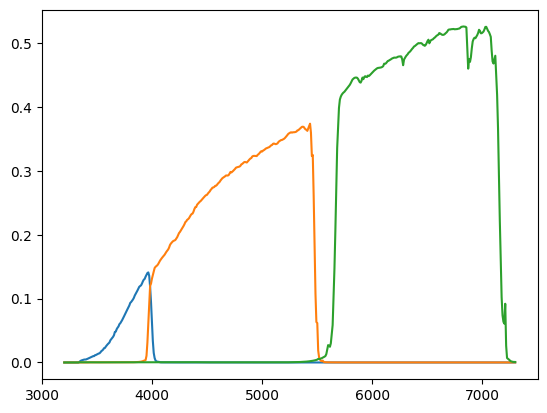

In [4]:
decam_filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g', 'decam2014-r')
wave = np.linspace(3200, 7300, 500)
for f in decam_filters:
    plt.plot(wave, f.interpolator(wave), label=f.name)


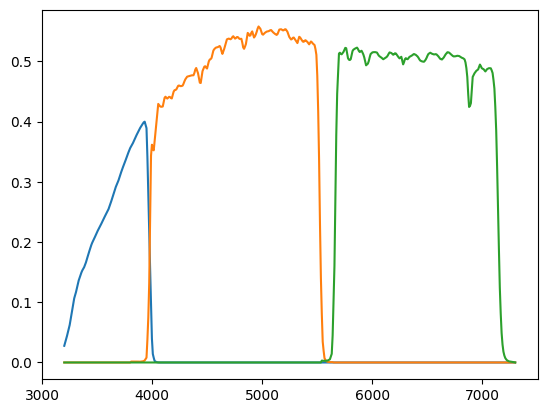

In [5]:
cfht_filters = speclite.filters.load_filters('cfht_megacam-u', 'cfht_megacam-g',
                                            'cfht_megacam-r')
for f in cfht_filters:
    plt.plot(wave, f.interpolator(wave), label=f.name)


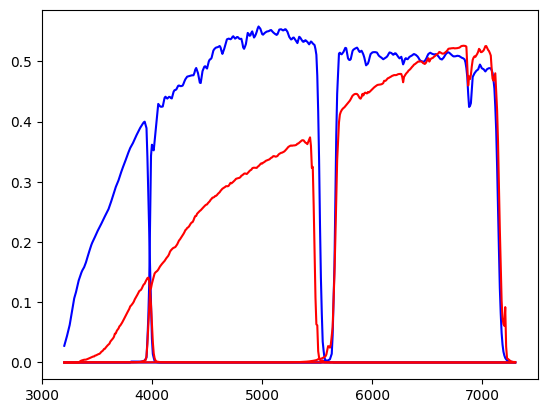

In [6]:
for f in cfht_filters:
    plt.plot(wave, f.interpolator(wave), label=f.name, color='b')
for f in decam_filters:
    plt.plot(wave, f.interpolator(wave), label=f.name, color='r')


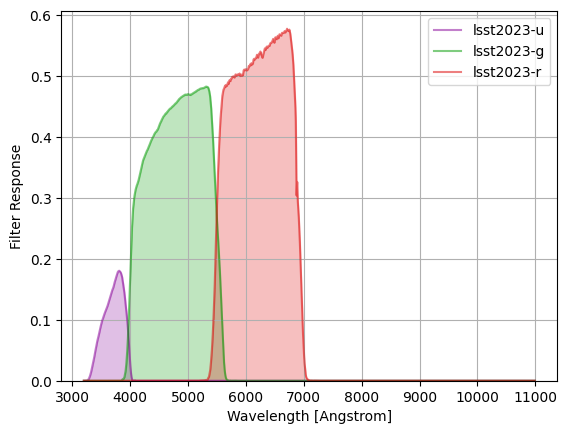

In [7]:
lsst_filters = speclite.filters.load_filters('lsst2023-u', 'lsst2023-g', 'lsst2023-r')
speclite.filters.plot_filters(lsst_filters)


In [8]:
# Read CFHT data tables...
def read_table(fn, wavelengths, sep=None, wave_scale=10., trans_scale=0.01):
    f = open(fn)
    qe = []
    for line in f.readlines():
        words = line.strip().split(sep=sep)
        #if len(words) != 2:
        #    continue
        try:
            f1,f2 = float(words[0]), float(words[1])
        except:
            continue
        qe.append([wave_scale * f1, trans_scale * f2])
    qe = np.array(qe)
    if wavelengths is None:
        return qe
    qe_wave = qe[:,0] * u.Angstrom
    qe_frac = qe[:,1]
    qe = np.interp(wavelengths, qe_wave, qe_frac)
    return qe

In [9]:
def read_lsst_throughput(fn, basedir='lsst-throughputs-1.9', wave_factor = 10.,
                        assert_2_words=True):
    fullfn = os.path.join(basedir, fn)
    vals = []
    for line in open(fullfn).readlines():
        line = line.strip()
        if line.startswith('#'):
            continue
        words = line.split()
        if len(words) == 0:
            continue
        if assert_2_words:
            assert(len(words) == 2)
        vals.append((float(words[0]), float(words[1])))
    vals = np.array(vals)
    # Bizarro subaru m1 file is not sorted!!
    I = np.argsort(vals[:,0])
    vals = vals[I,:]
    # Wavelength (nm->A), throughput
    return vals[:,0] * wave_factor, vals[:,1]

In [10]:
sky_wave = np.arange(3000, 7300) * u.angstrom

# CCD QE
qe = read_table('cfht/QE_camera.dat', sky_wave)
# Optics_TR.dat
optics = read_table('cfht/Optics_TR.dat', sky_wave)
# Mirror - Al_coating.dat
mirror = read_table('cfht/Al_coating.dat', sky_wave)

cfht_thru = interp1d(sky_wave, qe * optics * mirror)


In [11]:
atm = interp1d(*read_lsst_throughput('atmos_std.dat'))

In [12]:
cfht_atm = atm

atmo = cfht_atm(sky_wave)
thru = cfht_thru(sky_wave)

In [13]:
from matplotlib.colors import TABLEAU_COLORS
def tab_color(c):
    return TABLEAU_COLORS['tab:'+c]


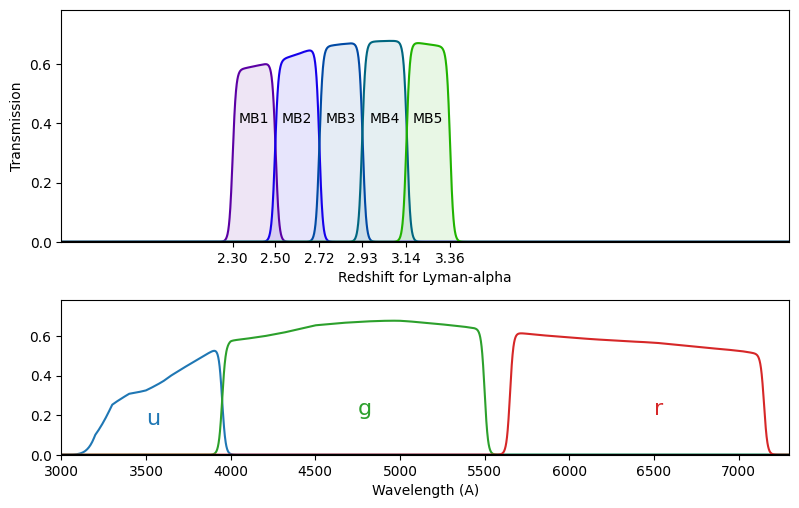

In [31]:
def fake_u_filt(wave):
    wave = wave.value
    return (1 + np.tanh(-(wave - 3950) / 20)) / 2
    #return np.exp(-0.5 * np.maximum(0, (wave-3950) * np.abs(wave-3950) / 100**2))
    #return np.mimum(1.0, np.exp(-0.5 * (wave - 3950)**2 / (100**2)))

def fake_g_filt(wave):
    wave = wave.value
    return (1 + np.tanh((wave - 3950) / 20) * np.tanh(-(wave-5500) / 20)) / 2

def fake_r_filt(wave):
    wave = wave.value
    return (1 + np.tanh((wave - 5650) / 20) * np.tanh(-(wave-7150) / 20)) / 2

def fake_mb1_filt(wave):
    wave = wave.value
    return (1 + np.tanh((wave - 4012) / 20) * np.tanh(-(wave - 4266) / 20)) / 2
def fake_mb2_filt(wave):
    wave = wave.value
    return (1 + np.tanh((wave - 4262) / 20) * np.tanh(-(wave - 4524) / 20)) / 2
def fake_mb3_filt(wave):
    wave = wave.value
    return (1 + np.tanh((wave - 4524) / 20) * np.tanh(-(wave - 4780) / 20)) / 2
def fake_mb4_filt(wave):
    wave = wave.value
    return (1 + np.tanh((wave - 4776) / 20) * np.tanh(-(wave - 5042) / 20)) / 2
def fake_mb5_filt(wave):
    wave = wave.value
    return (1 + np.tanh((wave - 5038) / 20) * np.tanh(-(wave - 5296) / 20)) / 2
    

yt = [0, 0.2, 0.4, 0.6]

atmo = cfht_atm(sky_wave)
thru = cfht_thru(sky_wave)
#plt.figure(figsize=(12,5))
plt.subplots(nrows=2, ncols=1, height_ratios=[0.6, 0.4], figsize=(8,5)) # sharex=True, 
plt.subplots_adjust(hspace=0, left=0.08, right=0.99, bottom=0.1, top=0.99)
plt.subplot(2,1,2)
plt.plot(sky_wave, thru*fake_u_filt(sky_wave), color=tab_color('blue'));
plt.plot(sky_wave, thru*fake_g_filt(sky_wave), color=tab_color('green'));
plt.plot(sky_wave, thru*fake_r_filt(sky_wave), color=tab_color('red'));
#plt.text(np.sum(thru*fake_u_filt(sky_wave)*sky_wave) / np.sum(thru*fake_u_filt(sky_wave)), 0.15, 'u')

plt.text(3500, 0.15, 'u', fontsize=16, color=tab_color('blue'))
plt.text(4750, 0.2, 'g', fontsize=16, color=tab_color('green'))
plt.text(6500, 0.2, 'r', fontsize=16, color=tab_color('red'))

yl,yh = plt.ylim()
plt.ylim(0, yh*1.1)
plt.axhline(0, color='k')
plt.xlabel('Wavelength (A)')

plt.yticks(yt)

plt.subplot(2,1,1)

def norm(*c):
    c = np.array(c)
    return np.array([1, 0.8, 1]) * c / np.sum(c)
    
c1=norm(124/255,0,222/255)
c2=norm(23/255, 0, 255/255)
c3=norm(0, 142/255, 255/255)
c4=norm(0, 255/255, 255/255)
c5=norm(36/255, 255/255, 0)

plt.plot(sky_wave, thru*fake_mb1_filt(sky_wave), color=c1);
plt.plot(sky_wave, thru*fake_mb2_filt(sky_wave), color=c2);
plt.plot(sky_wave, thru*fake_mb3_filt(sky_wave), color=c3);
plt.plot(sky_wave, thru*fake_mb4_filt(sky_wave), color=c4);
plt.plot(sky_wave, thru*fake_mb5_filt(sky_wave), color=c5);

plt.fill_between(sky_wave.value, 0, thru*fake_mb1_filt(sky_wave), color=c1, alpha=0.1);
plt.fill_between(sky_wave.value, 0, thru*fake_mb2_filt(sky_wave), color=c2, alpha=0.1);
plt.fill_between(sky_wave.value, 0, thru*fake_mb3_filt(sky_wave), color=c3, alpha=0.1);
plt.fill_between(sky_wave.value, 0, thru*fake_mb4_filt(sky_wave), color=c4, alpha=0.1);
plt.fill_between(sky_wave.value, 0, thru*fake_mb5_filt(sky_wave), color=c5, alpha=0.1);

for i,mb in enumerate([fake_mb1_filt, fake_mb2_filt, fake_mb3_filt, fake_mb4_filt, fake_mb5_filt]):
    plt.text(np.sum(sky_wave.value * mb(sky_wave)) / np.sum(mb(sky_wave)), 0.4,
             'MB%i' % (i+1), color='k', ha='center')

yl,yh = plt.ylim()
plt.ylim(0, yh*1.1)
plt.axhline(0, color='k')
plt.yticks(yt)


#plt.xlim(min(sky_wave.value), max(sky_wave.value))
plt.ylabel('Transmission')

#plt.title('Proposed Medium-band filters')
#plt.title('Assumed CFHT filters')
#plt.legend();
#plt.xlim(3000, 4500)

plt.subplot(2,1,1)
plt.xlim(min(sky_wave.value), max(sky_wave.value))
plt.subplot(2,1,2)
plt.xlim(min(sky_wave.value), max(sky_wave.value))

plt.savefig('mb.png');

if False:
    xt,_ = plt.xticks()
    xl,xh = plt.xlim()
    plt.twiny()
    plt.xlim(xl,xh)
    xt = [4012, 4262, 4524, 4776, 5038, 5296]
    zl = ['%.2f' % (x / 1216 - 1.) for x in xt]
    plt.xticks(xt, zl)
    plt.xlabel('Redshift for Lyman-alpha')
    plt.savefig('mb2.png');


plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,1)
xt = [4012, 4262, 4524, 4776, 5038, 5296]
zl = ['%.2f' % (x / 1216 - 1.) for x in xt]
plt.xticks(xt, zl)
plt.xlabel('Redshift for Lyman-alpha')

plt.savefig('mb2.png');


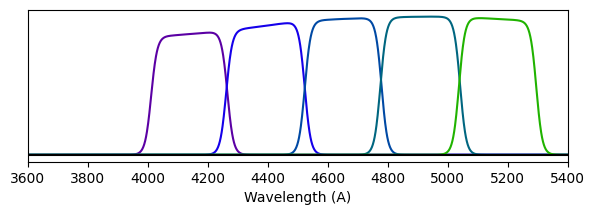

In [15]:
plt.figure(figsize=(6,2))
plt.subplots_adjust(left=0.05, right=0.95, top=0.98, bottom=0.22)
plt.plot(sky_wave, thru*fake_mb1_filt(sky_wave), color=c1);
plt.plot(sky_wave, thru*fake_mb2_filt(sky_wave), color=c2);
plt.plot(sky_wave, thru*fake_mb3_filt(sky_wave), color=c3);
plt.plot(sky_wave, thru*fake_mb4_filt(sky_wave), color=c4);
plt.plot(sky_wave, thru*fake_mb5_filt(sky_wave), color=c5);
plt.axhline(0, color='k')
plt.xlim(3600,5400)
plt.xlabel('Wavelength (A)')
plt.yticks([])
plt.savefig('filters.png')

In [16]:
from astropy.table import Table

In [17]:
fmt = 'ascii.ecsv'
tilefn = os.path.expanduser('~/ibis-observing/obstatus/ibis-tiles.ecsv')
tiles = Table.read(tilefn, format=fmt)


In [18]:
tiles

OBJECT,TILEID,RA,DEC,FILTER,DESIGNHA,PRIORITY,PASS,IN_IBIS,EBV_MED,EFFTIME_TOT,DONE,EFFTIME_GOAL
str25,int32,float64,float64,str4,float64,float64,int16,int16,float32,float32,int16,float32
IBIS_deep_xmm_M411_1,1,35.751,-4.25,M411,0.0,3.0,0,1,0.024897,208.83,1,458.97
IBIS_deep_xmm_M411_2,2,35.438,-4.225,M411,0.0,3.0,0,1,0.023187,275.73,1,452.81
IBIS_deep_xmm_M411_3,3,35.156,-4.368,M411,0.0,3.0,0,1,0.022136,201.7,1,449.07
IBIS_deep_xmm_M411_4,4,34.969,-4.622,M411,0.0,3.0,0,1,0.021648,296.88,1,447.34
IBIS_deep_xmm_M411_5,5,34.901,-4.931,M411,0.0,3.0,0,1,0.021954,369.33,1,448.42
IBIS_deep_xmm_M411_6,6,34.952,-5.243,M411,0.0,3.0,0,1,0.022813,238.93,1,451.48
IBIS_deep_xmm_M411_7,7,35.107,-5.52,M411,0.0,3.0,0,1,0.023991,265.57,1,455.7
IBIS_deep_xmm_M411_8,8,35.343,-5.733,M411,0.0,3.0,0,1,0.024943,235.0,1,459.14
IBIS_deep_xmm_M411_9,9,35.632,-5.866,M411,0.0,3.0,0,1,0.025645,324.33,1,461.69


In [19]:
from astrometry.util.starutil_numpy import *

In [20]:
lbtoradec

<function astrometry.util.starutil_numpy.lbtoradec(l, b)>

rlo 121.26852639362316
rhi 264.23228331705957
rlo 74.88183193701546
rhi 310.5629726066377


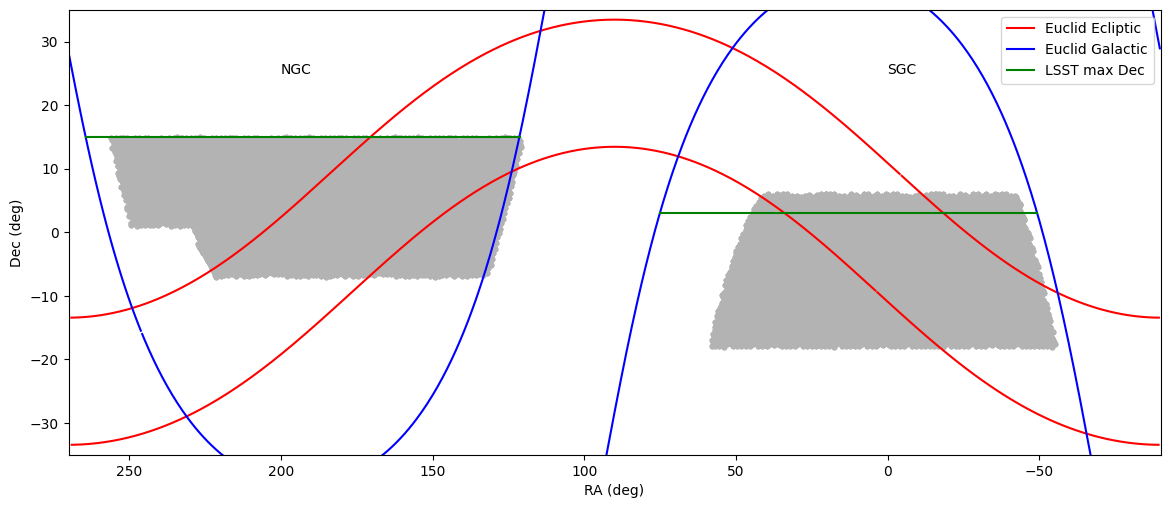

In [22]:
def shift_ra(r):
    return r + -360 * (r>270)

def draw_breaks(r, d, *args, **kwargs):
    dist = np.hypot(np.diff(r), np.diff(d))
    ibreak = np.flatnonzero(dist > 10)
    ilast = 0
    rr,dd = [],[]
    for ib in list(ibreak)+[None]:
        if ib is not None:
            s = slice(ilast, ib)
            ilast = ib+1
        else:
            s = slice(ilast, -1)
        plt.plot(r[s], d[s], *args, **kwargs)
        kwargs = {}
        #rr.append(r[s])
        #dd.append(d[s])
    #plt.plot(rr, dd, *args, **kwargs)

plt.figure(figsize=(12, 5))
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.99, top=0.99)

ra,dec = tiles['RA'], tiles['DEC']
I = np.flatnonzero(dec > -20)
ra = ra[I]
dec = dec[I]
plt.plot(shift_ra(ra), dec, '.', color='0.7')
ax = plt.axis()

ll = np.linspace(0, 360, 500)
bb = np.zeros_like(ll) + 23.0

eb = np.zeros_like(ll) + 10.0
r,d = ecliptictoradec(ll, eb)
draw_breaks(shift_ra(r), d, 'r-', label='Euclid Ecliptic')
eb = np.zeros_like(ll) - 10.0
r,d = ecliptictoradec(ll, eb)
draw_breaks(shift_ra(r), d, 'r-')

r,d = lbtoradec(ll, bb)
draw_breaks(shift_ra(r), d, 'b-', label='Euclid Galactic')


i = np.argmin(np.abs(d[r<180] - 15))
rlo = r[r<180][i]
print('rlo', rlo)
i = np.argmin(np.abs(d[r>180] - 15))
rhi = r[r>180][i]
print('rhi', rhi)
plt.plot(shift_ra(np.array([rlo, rhi])), [+15, +15], 'g-')

bb = np.zeros_like(ll) - 23.0
r,d = lbtoradec(ll, bb)
plt.plot(shift_ra(r), d, 'b-')

i = np.argmin(np.abs(d[r<180] - 3))
rlo = r[r<180][i]
print('rlo', rlo)
i = np.argmin(np.abs(d[r>180] - 3))
rhi = r[r>180][i]
print('rhi', rhi)
plt.plot(shift_ra(np.array([rlo, rhi])), [+3, +3], 'g-', label='LSST max Dec')


plt.axis(ax)
plt.ylim(-35, +35)
plt.xlim(270, -90)

plt.text(200, +25, 'NGC')
plt.text(0, +25, 'SGC')

#plt.title('IBIS footprint')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

plt.legend()

plt.savefig('footprint.png')

In [24]:
from astroquery.esa.euclid import Euclid

In [25]:
Euclid

In [26]:
tables = Euclid.load_tables(only_names=True, include_shared_tables=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [95]:
[t.name for t in tables]

['catalogue.mer_catalogue',
 'catalogue.mer_cutouts',
 'catalogue.mer_morphology',
 'catalogue.phz_classification',
 'catalogue.phz_galaxy_sed',
 'catalogue.phz_nir_physical_parameters',
 'catalogue.phz_photo_z',
 'catalogue.phz_physical_parameters',
 'catalogue.phz_qso_physical_parameters',
 'catalogue.phz_star_sed',
 'catalogue.phz_star_template',
 'catalogue.spectro_line_features_catalog_spe_atomic_indices',
 'catalogue.spectro_line_features_catalog_spe_continuum_features',
 'catalogue.spectro_line_features_catalog_spe_line_features_cat',
 'catalogue.spectro_line_features_catalog_spe_molecular_indices',
 'catalogue.spectro_model_catalog_spe_galaxy_models',
 'catalogue.spectro_model_catalog_spe_lines_catalog',
 'catalogue.spectro_model_catalog_spe_qso_models',
 'catalogue.spectro_model_catalog_spe_star_models',
 'catalogue.spectro_zcatalog_spe_classification',
 'catalogue.spectro_zcatalog_spe_galaxy_candidates',
 'catalogue.spectro_zcatalog_spe_qso_candidates',
 'catalogue.spectro_zc

In [96]:
t = 'sedm.vmpz_healpix_footprint_mask'

In [98]:
m = Euclid.load_table(t)

In [102]:
print(m)

TAP Table name: sedm.vmpz_healpix_footprint_mask
Description: None
Size (bytes): 0
Num. columns: 22


In [101]:
[c.name for c in m.columns]

['basic_download_data_oid',
 'checksum_list',
 'creation_date',
 'datalabs_path',
 'data_set_release',
 'data_size',
 'file_name_list',
 'file_path',
 'file_type_list',
 'filter_name',
 'ingested',
 'observation_id_list',
 'patch_id_list',
 'product_id',
 'product_type',
 'provenance_id',
 'published',
 'purpose',
 'release_date',
 'release_name',
 'tile_index_list',
 'to_be_published']

In [104]:
m['basic_download_data_oid']

TypeError: 'TapTableMeta' object is not subscriptable

In [ ]:
dpdHealpixFootprintMaskVMPZ

In [103]:
dir(m)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_column',
 'columns',
 'description',
 'get_qualified_name',
 'name',
 'schema',
 'size_bytes']